MacBERTh program reserves

This MacBERTh program uses the transformers library to find words used in a text that are similar in semantics and meaning as certain pre-selected keywords. 
## Using cosine similarities to find closely related words.

Updates: June 14, 2024:
Lucas and Jerry merged their versions of MacBERTh-based cosine similarity comparison algorithms.
Author: Jerry Zou
Edited by Lucas Ma

In [44]:
from transformers import AutoTokenizer, AutoModel
import torch, string, json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# from docx import Document
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd

In [20]:
modelName = "emanjavacas/MacBERTh"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModel.from_pretrained(modelName)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
def preprocess_text(docx):
    content = Document(docx)
    lowercaseWords = []
    translator = str.maketrans('', '', string.punctuation)

    for paragraph in content.paragraphs:
        for run in paragraph.runs:
            text = run.text
            words = text.split()
            for word in words:
                word = word.translate(translator)
                lowercaseWords.append(word.lower())
    joinedList = " ".join(lowercaseWords)
    return tokenizer.tokenize(joinedList)
# FOR DEBUG: print(preprocess_text("/Users/Jerry/Desktop/test.docx")[:40])

In [ ]:
def encode_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    #tokens = tokenizer.tokenize(text)
    #combined_word = tokenizer.convert_tokens_to_string(tokens)
    print(f"Encoding word: {text}")
    return outputs.last_hidden_state.mean(dim=1)  # Use the mean of the hidden states as the embedding

document_text = "/Users/Jerry/Desktop/test.docx"
tokenizedText = preprocess_text(document_text)
tokenTextEmbedding = {token: encode_text(token, tokenizer, model) for token in tokenizedText}

keywords = ["ciuilitie", "Sathan", "school", "instruction"]
tokenKeywordEmbeddings = {token: encode_text(token, tokenizer, model) for token in keywords}

# for token, embedding in tokenTextEmbedding.items():
#     print(f"Token: {token}, Embedding: {embedding}")


In [ ]:
def find_similar_words(keyword_embeddings, token_embeddings):
    similar_words = {}
    for keyword, keyword_emb in keyword_embeddings.items():
        similarities = []
        for token, token_emb in token_embeddings.items():
            sim = cosine_similarity(keyword_emb, token_emb)
            similarities.append((token, float(sim[0][0])))
        # Sort by similarity score in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)
        similar_words[keyword] = similarities
    return similar_words

similar_words = find_similar_words(tokenKeywordEmbeddings, tokenTextEmbedding)

shortenedSimilarWords = {}

for keyword, words in similar_words.items():
    #print(f"Words similar to '{keyword}':")
    for word, similarity in words[:50]:
        #print(f" {word}: {similarity}")
        shortenedSimilarWords[keyword] = words[:12]

print(shortenedSimilarWords)

In [57]:
jsonStorage = "SimilarWords.json"
with open(jsonStorage, "w") as file:
    json.dump(shortenedSimilarWords, file)

---

The code below are for presentation and visualization purposes using the data generated above.

In [58]:
#Presentation
def encode_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        print(inputs)
        outputs = model(**inputs)
    print(f"Encoding word: {text}")
    return outputs.last_hidden_state.mean(dim=1)

document_text = "But you will say, what needeth all this Discourse, touching the Danger of Sea-men;"\
                "we are met together for another purpose, to giue thanks vnto God?"
tokenizedText = preprocess_text(document_text)
tokenTextEmbedding = {token: encode_text(token, tokenizer, model) for token in tokenizedText}

PackageNotFoundError: Package not found at 'But you will say, what needeth all this Discourse, touching the Danger of Sea-men;we are met together for another purpose, to giue thanks vnto God?'

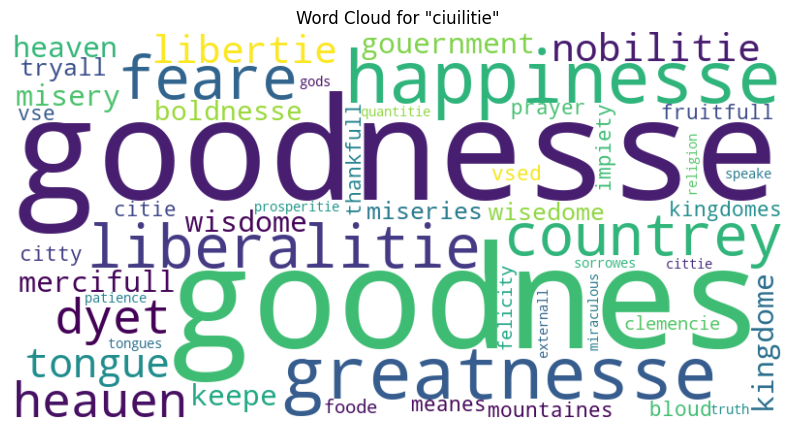

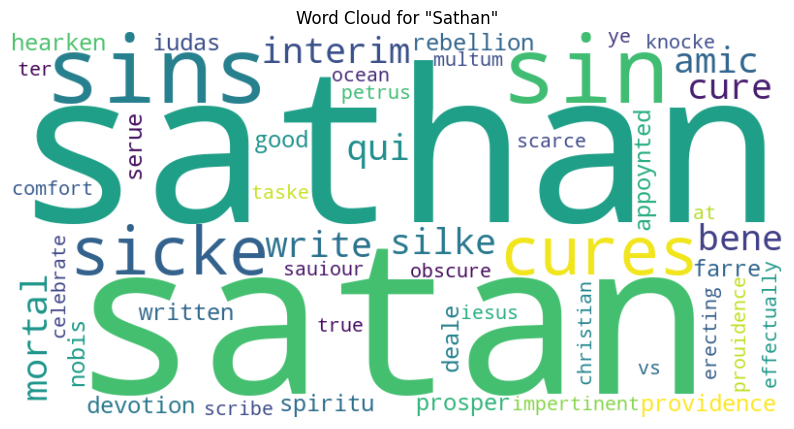

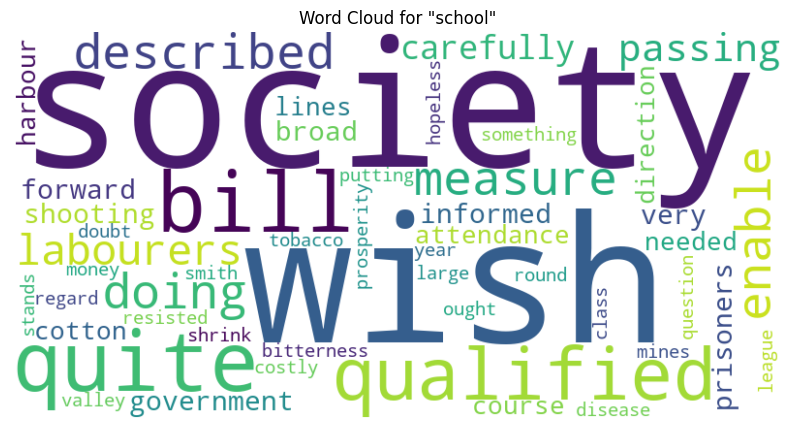

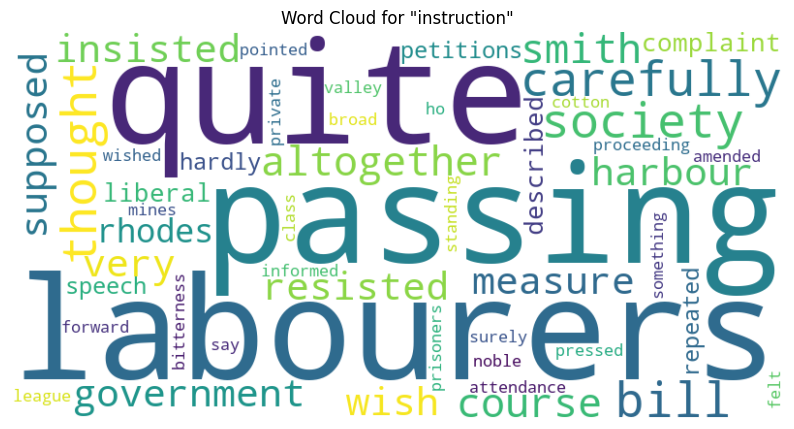

In [34]:
from wordcloud import WordCloud

def plot_similar_words_wordcloud(similar_words, top_n=50):
    for keyword, similarities in similar_words.items():
        word_freq = {word: score for word, score in similarities[:top_n]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for "{keyword}"')
        plt.show()

# Plot word clouds for the top 50 similar words for each keyword
plot_similar_words_wordcloud(similar_words, top_n=50)


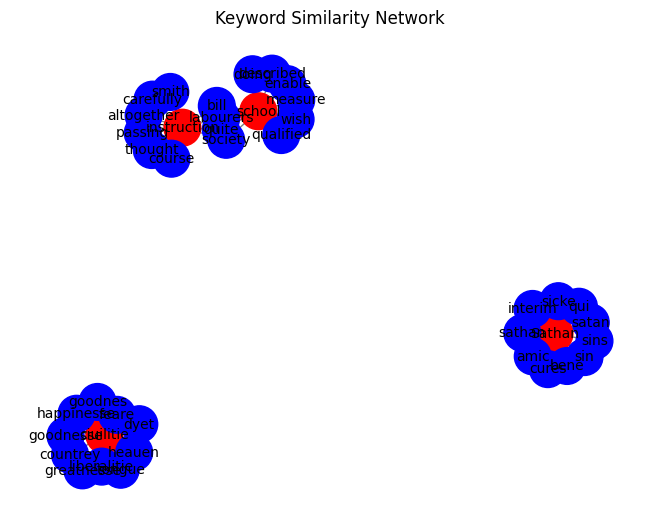

In [42]:
def plot_similarity_network(similar_words, top_n=10):
    G = nx.Graph()
    for keyword, similarities in similar_words.items():
        G.add_node(keyword, color='red')
        for token, score in similarities[:top_n]:
            G.add_node(token, color='blue')
            G.add_edge(keyword, token, weight=score)
    
    pos = nx.spring_layout(G)
    colors = [G.nodes[node]['color'] for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=700, edge_color='gray', linewidths=1, font_size=10)
    
    plt.title('Keyword Similarity Network')
    plt.show()

# Plot a network graph of the top 10 similar words for each keyword
plot_similarity_network(similar_words, top_n=10)


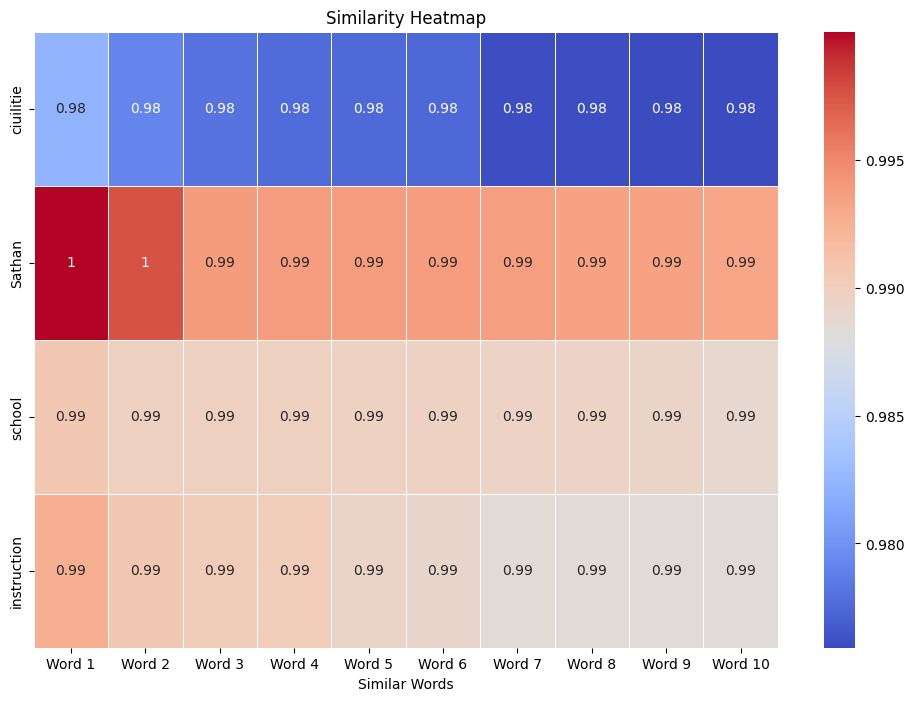

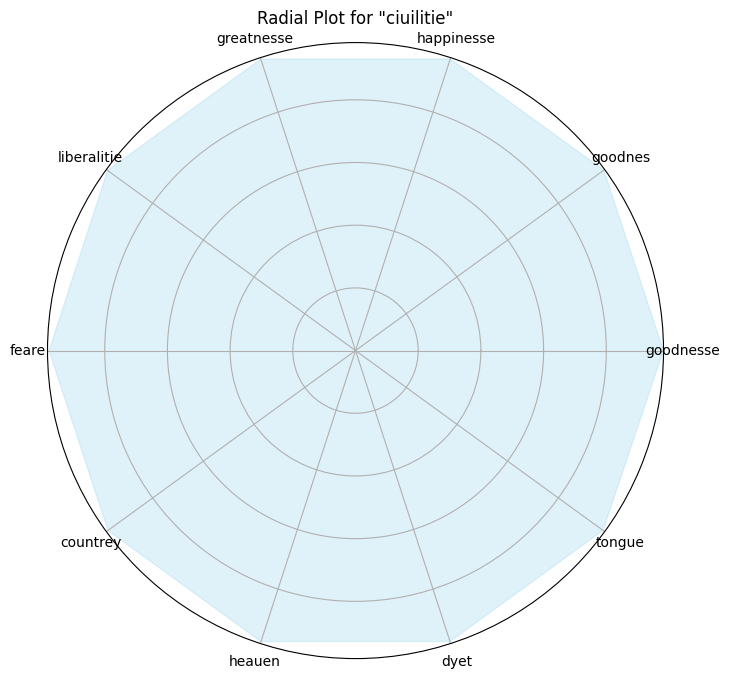

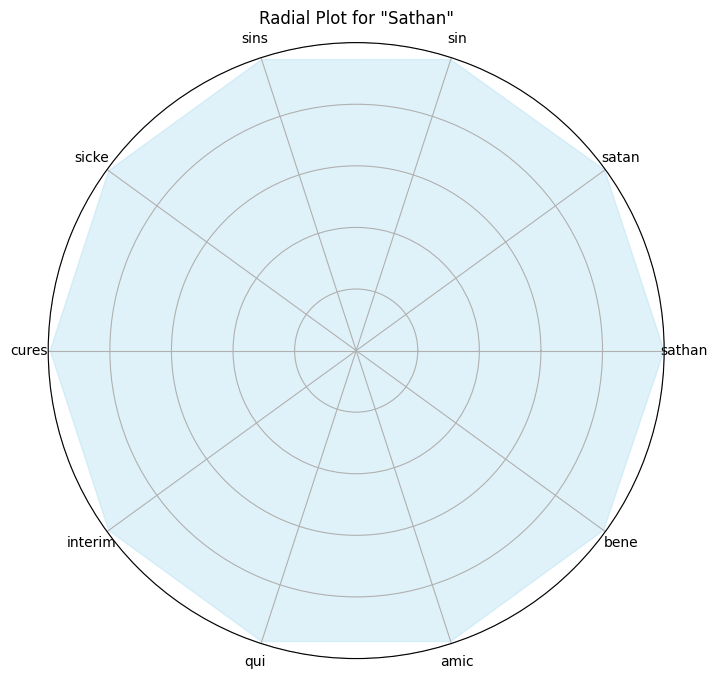

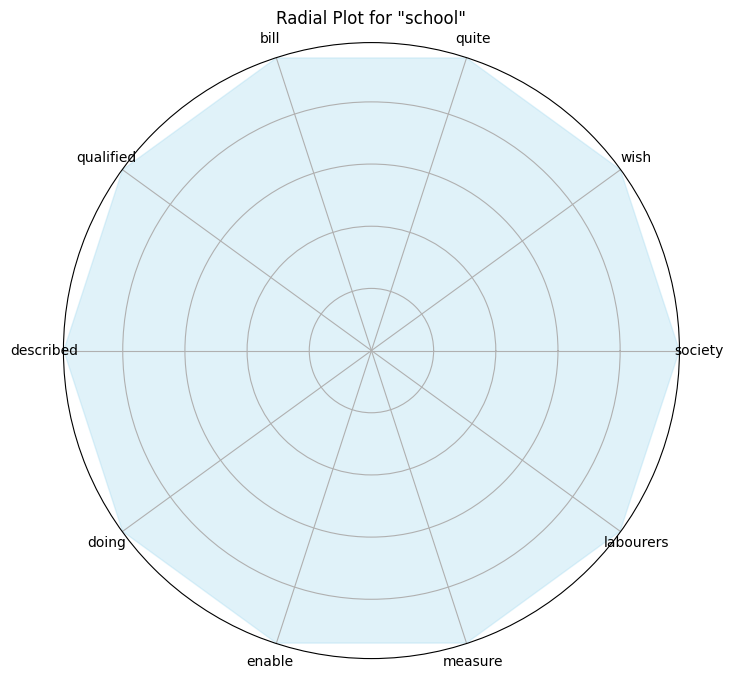

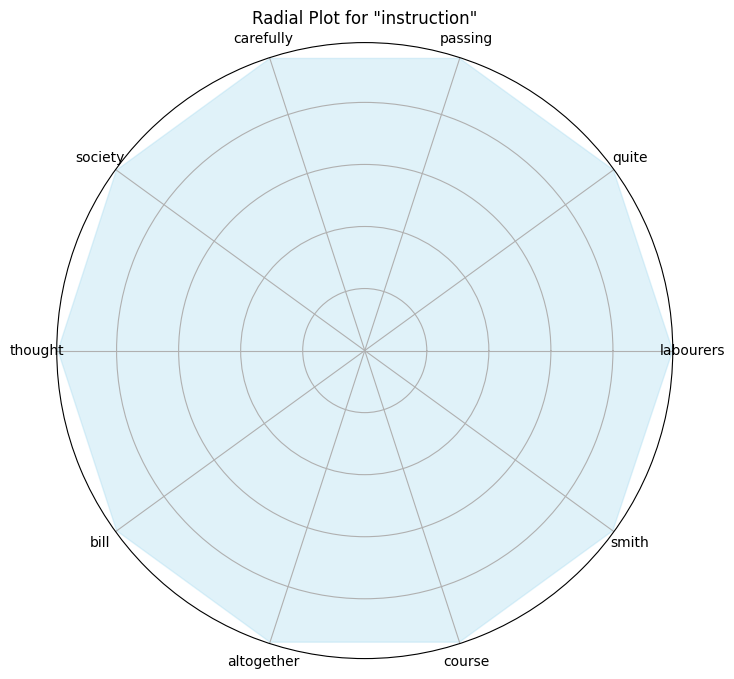

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_similar_words_radial(similar_words, top_n=10):
    for keyword, similarities in similar_words.items():
        words, scores = zip(*similarities[:top_n])
        
        angles = np.linspace(0, 2 * np.pi, len(words), endpoint=False).tolist()
        scores = list(scores) + [scores[0]]
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.fill(angles, scores, color='skyblue', alpha=0.25)
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(words)
        ax.set_title(f'Radial Plot for "{keyword}"')
        plt.show()

# Plot radial plots for the top 10 similar words for each keyword
plot_similar_words_radial(similar_words, top_n=10)
